In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('mplstyle')

In [2]:
input_images = [
    "AAAA.SP2B.PBCOR.SMOOTH.FITS",
    "BBBB.SP2B.PBCOR.SMOOTH.FITS",
    "CCCC.SP2B.PBCOR.SMOOTH.FITS",
    "DDDD.SP2B.PBCOR.SMOOTH.FITS",
    "EEEE.SP2B.PBCOR.SMOOTH.FITS",
    "FFFF.SP2B.PBCOR.SMOOTH.FITS",
    "GGGG.SP2B.PBCOR.SMOOTH.FITS"
]

origna_catalog = [img.replace(".SMOOTH.FITS", ".pybdsf.srl.fits") for img in input_images]
smooth_catalog = [img.replace(".FITS", ".pybdsf.srl.fits") for img in input_images]

match_radius = 10 * u.arcsec

In [3]:
def find_sources(catalog):
    with fits.open(catalog) as hdul:
        ra = hdul[1].data["RA"]   # RA in degrees
        dec = hdul[1].data["DEC"]  # DEC in degrees
        flux = hdul[1].data["Total_flux"]  # Total flux density
        flux_err = hdul[1].data["E_Total_flux"]  # Flux error (check column name)

    return ra, dec, flux, flux_err

def match_sources(catalog1, catalog2, match_radius=40*u.arcsec, flux_thresh=100.0):

    ra1, dec1, flux1, flux_err1 = find_sources(catalog1)
    ra2, dec2, flux2, flux_err2 = find_sources(catalog2)
    
    # Apply flux threshold on catalog1
    flux_mask = flux1 < flux_thresh
    ra1, dec1, flux1, flux_err1 = ra1[flux_mask], dec1[flux_mask], flux1[flux_mask], flux_err1[flux_mask]

    # Convert to SkyCoord objects
    cat1_coords = SkyCoord(ra=ra1 * u.deg, dec=dec1 * u.deg)
    cat2_coords = SkyCoord(ra=ra2 * u.deg, dec=dec2 * u.deg)

    # Find nearest neighbor in cat2 for each cat1 source
    idx, d2d, _ = cat1_coords.match_to_catalog_sky(cat2_coords)
    
    # Set matching radius
    matched_mask = d2d < match_radius
    
    # Apply mask to get matched indices
    matched_cat1 = np.where(matched_mask)[0]  
    matched_cat2 = idx[matched_mask]      
    
    percent_matched = 100 * np.sum(matched_mask) / len(cat1_coords)
    print(f"Matched sources: {len(matched_cat1)} / {len(cat1_coords)} ({percent_matched:.1f}%)")
    
    return (ra1[matched_cat1], dec1[matched_cat1], flux1[matched_cat1], flux_err1[matched_cat1],
            ra2[matched_cat2], dec2[matched_cat2], flux2[matched_cat2], flux_err2[matched_cat2])


In [4]:

# --- compute median + IQR errors ---
def compute_ratio_stats(ratio):
    ratio = ratio[np.isfinite(ratio)]
    median = np.median(ratio)
    p25, p75 = np.percentile(ratio, [25, 75])
    return median, p75 - median, median - p25

# === Plot positional offsets ===
def plot_positional_offsets(ra1, dec1, ra2, dec2, cat1_name, cat2_name, save=True):
    delta_ra = 3600 * (ra1 - ra2) * np.cos(np.radians(dec1))
    delta_dec = 3600 * (dec1 - dec2)

    max_offset = np.max([np.abs(delta_ra).max(), np.abs(delta_dec).max()])
    lim = max_offset * 1.2

    fig = plt.figure(figsize=(7, 7))
    grid = plt.GridSpec(4, 4, hspace=0.05, wspace=0.05)

    # Central scatter
    main_ax = fig.add_subplot(grid[1:4, 0:3])
    main_ax.scatter(
        delta_ra, delta_dec,
        edgecolors='turquoise', facecolors='none',
        marker='o', s=40, linewidth=2,
        label=rf'\rm{{{cat1_name} - {cat2_name}}}'
    )
    main_ax.axhline(0, color='k', linestyle=':', linewidth=2)
    main_ax.axvline(0, color='k', linestyle=':', linewidth=2)
    main_ax.set_xlim(-lim, lim)
    main_ax.set_ylim(-lim, lim)
    main_ax.set_xlabel(r'$\delta_\mathrm{RA}$ (arcsec)')
    main_ax.set_ylabel(r'$\delta_\mathrm{DEC}$ (arcsec)')
    main_ax.set_aspect('equal')
    main_ax.legend(fontsize='x-small', frameon=True, loc=3)

    # Histogram RA
    hist_ra = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
    hist_ra.hist(delta_ra, bins=30, color='turquoise', density=True,
                 histtype='step', linewidth=1)
    hist_ra.axvline(0, color='k', linestyle=':', linewidth=2)
    hist_ra.set_ylabel(r'Density')
    plt.setp(hist_ra.get_xticklabels(), visible=False)

    # Histogram Dec
    hist_dec = fig.add_subplot(grid[1:4, 3], sharey=main_ax)
    hist_dec.hist(delta_dec, bins=30, orientation='horizontal',
                  color='turquoise', density=True, histtype='step', linewidth=1)
    hist_dec.axhline(0, color='k', linestyle=':', linewidth=2)
    hist_dec.set_xlabel(r'Density')
    plt.setp(hist_dec.get_yticklabels(), visible=False)

    fig.align_ylabels([main_ax, hist_ra])
    fig.align_xlabels([main_ax, hist_dec])

    plt.tight_layout()
    # if save:
    #     plt.savefig(f'positional_offsets_{cat1_name}_{cat2_name}.pdf', bbox_inches='tight', dpi=300)
    plt.show()

# === Plot flux comparison ===
def plot_flux_comparison(ra1, dec1, flux1, flux1_err, ra2, dec2, flux2, flux2_err,
                         cat1_name, cat2_name, save=True):

    fractional_deviation = (flux1 - flux2) / flux2
    ratio = flux1 / flux2
    median_ratio, errp_ratio, errm_ratio = compute_ratio_stats(ratio)

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True,
                            gridspec_kw={'height_ratios': [3., 1.]})

    # --- Top Panel: Flux–Flux comparison ---
    axs[0].errorbar(flux2, flux1, xerr=flux2_err, yerr=flux1_err,
                    fmt='o', color='C0', mec='C0', mfc='none', ms=4, alpha=0.9)

    min_flux = np.nanmin([flux1.min(), flux2.min()])
    max_flux = np.nanmax([flux1.max(), flux2.max()])
    axs[0].plot([min_flux, max_flux], [min_flux, max_flux], 'k--', lw=1,
                label='Equal Flux Line')

    axs[0].legend(loc='upper left', fontsize='small', frameon=True)
    axs[0].set_ylabel(rf'$S_{{\rm {cat1_name}}}\ \rm{{(Jy)}}$')
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')

    # --- Annotate flux ratio ---
    axs[0].text(0.95, 0.08,
                rf'$S_{{\rm {cat1_name}}} / S_{{\rm {cat2_name}}} = {median_ratio:.2f}^{{+{errp_ratio:.2f}}}_{{-{errm_ratio:.2f}}}$',
                transform=axs[0].transAxes, ha='right', va='bottom',
                fontsize='small', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # --- Bottom Panel: Fractional deviation ---
    axs[1].errorbar(flux2, fractional_deviation, xerr=flux2_err,
                    yerr=flux1_err/flux2, fmt='o', color='C1', mfc='none', ms=4)

    axs[1].axhline(0, color='k', ls='--', lw=1)
    axs[1].axhline(0.10, color='gray', ls='--', lw=1)
    axs[1].axhline(-0.10, color='gray', ls='--', lw=1)
    axs[1].set_ylabel(rf'$(S_{{\rm {cat1_name}}} - S_{{\rm {cat2_name}}}) / S_{{\rm {cat2_name}}}$')
    axs[1].set_xlabel(rf'$S_{{\rm {cat2_name}}}\ \rm{{(Jy)}}$')
    axs[1].set_xscale('log')

    plt.tight_layout(pad=0.2)
    # if save:
    #     plt.savefig(f'flux_comparison_{cat1_name}_{cat2_name}.pdf', bbox_inches='tight')
    plt.show()

# === Process multiple catalog pairs and generate LaTeX table ===
def process_catalog_pairs(catalog_pairs, match_radius=match_radius, save_plots=True):
    latex_rows = []

    for i, (cat1, cat2, _, _) in enumerate(catalog_pairs):
        # Auto-generate names: A, B, C... and A_smooth, B_smooth...
        name_orig = chr(ord('A') + i)
        name_smooth = f"{name_orig}_smooth"

        # --- Match sources ---
        ra1, dec1, flux1, flux1_err, ra2, dec2, flux2, flux2_err = match_sources(cat1, cat2, match_radius=match_radius)

        # --- Plot positional offsets ---
        plot_positional_offsets(ra1, dec1, ra2, dec2, name_orig, name_smooth, save=save_plots)

        # --- Plot flux comparison ---
        plot_flux_comparison(ra1, dec1, flux1, flux1_err, ra2, dec2, flux2, flux2_err,
                             name_orig, name_smooth, save=save_plots)

        # --- Compute flux ratio stats ---
        ratio = flux1 / flux2
        median_ratio, errp_ratio, errm_ratio = compute_ratio_stats(ratio)

        latex_rows.append((name_orig, name_smooth, median_ratio, errp_ratio, errm_ratio))

    # --- Generate LaTeX table ---
    print(r"\begin{table}[ht]")
    print(r"\centering")
    print(r"\caption{Median flux ratios for all catalogue pairs.}")
    print(r"\begin{tabular}{l c}")
    print(r"\hline")
    print(r"Catalogue Pair & Median $S_\mathrm{orig}/S_\mathrm{smooth}$ \\")
    print(r"\hline")
    for name_orig, name_smooth, median, errp, errm in latex_rows:
        print(rf"{name_orig}, {name_smooth} & ${median:.2f}^{{+{errp:.2f}}}_{{-{errm:.2f}}}$ \\")
    print(r"\hline")
    print(r"\end{tabular}")
    print(r"\label{{tab:flux_ratios}}")
    print(r"\end{table}")


In [5]:

catalog_pairs = []
for i, (cat1, cat2) in enumerate(zip(origna_catalog, smooth_catalog), start=1):
    name1 = f"Cat{i*2-1}"  # e.g., Cat1, Cat3, ...
    name2 = f"Cat{i*2}"    # e.g., Cat2, Cat4, ...
    catalog_pairs.append((cat1, cat2, name1, name2))

# --- Process all pairs ---
# process_catalog_pairs(catalog_pairs, match_radius=match_radius, save_plots=True)

In [6]:
def plot_summary_catalog_pairs(catalog_pairs, name='A', match_radius=10*u.arcsec):
    """
    Generate a multi-panel summary plot for multiple catalog pairs:
    - Top: Flux–Flux comparison
    - Remaining panels: Fractional deviations for each catalog pair
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import cycle


    n_pairs = len(catalog_pairs)
    fig, axs = plt.subplots(nrows=n_pairs+1, ncols=1, figsize=(8, 4 + 2*n_pairs),
                            gridspec_kw={'height_ratios':[3]+[1]*n_pairs}, sharex=True)

    if n_pairs == 1:
        axs = np.array(axs)  # ensure axs is iterable

    markers = cycle(['o', 's', 'D', '^', 'v', 'P', 'X'])
    colors = cycle(plt.cm.tab10.colors)

    # Store medians for annotation
    medians_text = []

    for i, (cat1, cat2, _, _) in enumerate(catalog_pairs):
        name_orig = chr(ord(name) + i)
        name_smooth = f"{name_orig}_s"

        marker = next(markers)
        color = next(colors)

        # --- Match sources ---
        ra1, dec1, flux1, flux1_err, ra2, dec2, flux2, flux2_err = match_sources(
            cat1, cat2, match_radius=match_radius)

        print(flux1.max())

        # --- Compute median flux ratio ---
        ratio = flux1 / flux2
        median_ratio, errp, errm = compute_ratio_stats(ratio)
        medians_text.append(rf"$S_{{{name_orig}}}/S_{{{name_smooth}}}={median_ratio:.2f}^{{+{errp:.2f}}}_{{-{errm:.2f}}}$")

        # --- Top panel: Flux–Flux ---
        axs[0].errorbar(flux2, flux1, xerr=flux2_err, yerr=flux1_err,
                        fmt=marker, mfc='none', ms=5, mec=color, mew=1, alpha=0.7,
                        label=rf"${name_orig}$, ${name_smooth}$", capsize=2)

        # --- Fractional deviation panels ---
        frac_dev = (flux1 - flux2)/flux2
        axs[i+1].errorbar(flux2, frac_dev, yerr=flux1_err/flux2, color=color,
                          fmt=marker, mfc='none', ms=5, mec=color, mew=1, alpha=0.7)

        # Handle extreme outliers
        mask_high = frac_dev > 1.1
        mask_low = frac_dev < -1.1
        axs[i+1].scatter(flux2[mask_high], np.ones_like(flux2[mask_high])*0.015,
                         marker=r'$\uparrow$', color='magenta', s=200, zorder=5)
        axs[i+1].scatter(flux2[mask_low], np.ones_like(flux2[mask_low])*-0.015,
                         marker=r'$\downarrow$', color='magenta', s=200, zorder=5)

        axs[i+1].set_ylabel(rf"$\delta_{{{name_smooth}}}$")
        axs[i+1].axhline(0, color='k', ls='--', lw=1)
        axs[i+1].axhline(0.2, color='gray', ls='--', lw=1)
        axs[i+1].axhline(-0.2, color='gray', ls='--', lw=1)
        axs[i+1].set_ylim(-.5, .5)

    # --- Top panel settings ---
    min_flux = min([np.nanmin(flux2) for _, _, _, _ in catalog_pairs])
    max_flux = max([np.nanmax(flux1) for _, _, _, _ in catalog_pairs])*1.5
    axs[0].plot([min_flux, max_flux], [min_flux, max_flux], 'k--', lw=1, label=r'$\rm{Equal\ Flux\ Line}$')
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_ylabel(r"$S \, \rm{Jy} $")
    axs[0].set_title(r"$\rm{Flux \, Comparison\ after\ PSF\ matching}$")
    axs[0].legend(frameon=True, fontsize='small')

    # Annotate median ratios
    axs[0].text(0.95, 0.05, "\n".join(medians_text), transform=axs[0].transAxes,
                ha='right', va='bottom', fontsize='small', bbox=dict(facecolor='white', alpha=0.75))

    # --- Bottom panel settings ---
    axs[-1].set_xlabel(r"$S_s \, \rm{Jy}$")
    for ax in axs:
        ax.set_xscale('log')

    fig.align_ylabels(axs)
    plt.tight_layout(pad=0.2)
    plt.show()


Matched sources: 125 / 145 (86.2%)
15.095040906068746
Matched sources: 149 / 159 (93.7%)
19.57844921550026
Matched sources: 159 / 175 (90.9%)
20.079940668246277
Matched sources: 161 / 189 (85.2%)
20.16037005592906
Matched sources: 154 / 170 (90.6%)
18.941731165321293
Matched sources: 151 / 166 (91.0%)
19.306832413499745
Matched sources: 163 / 178 (91.6%)
20.261818826271004


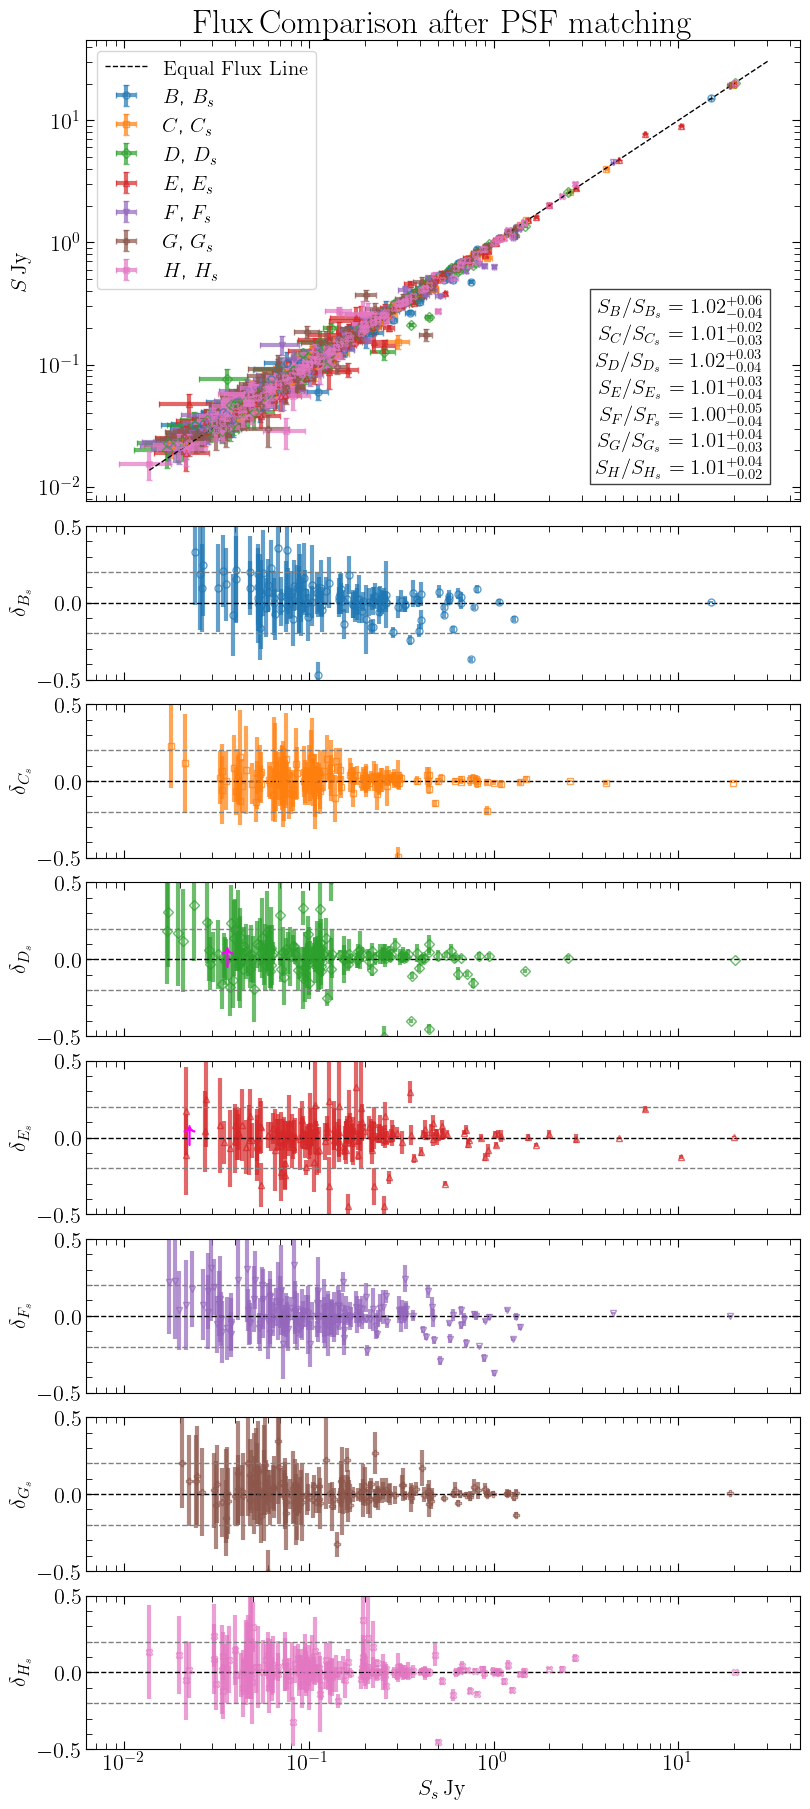

In [7]:
plot_summary_catalog_pairs(catalog_pairs, name='B', match_radius=match_radius)


Matched sources: 125 / 145 (86.2%)


/tmp/ipykernel_851354/1111551430.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


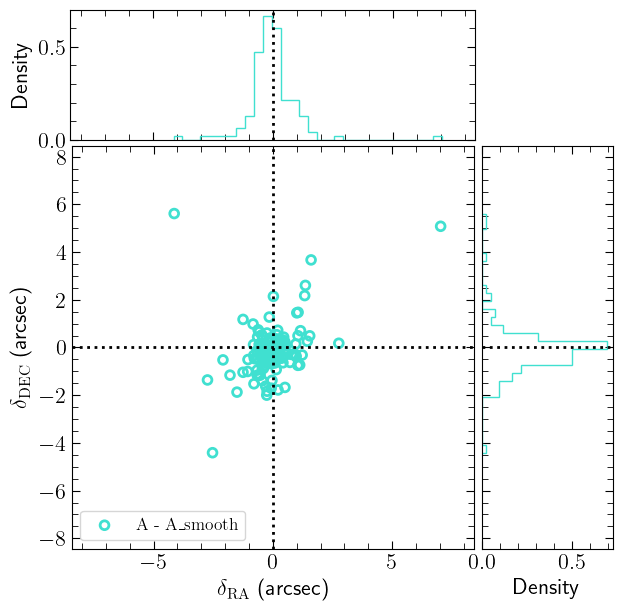

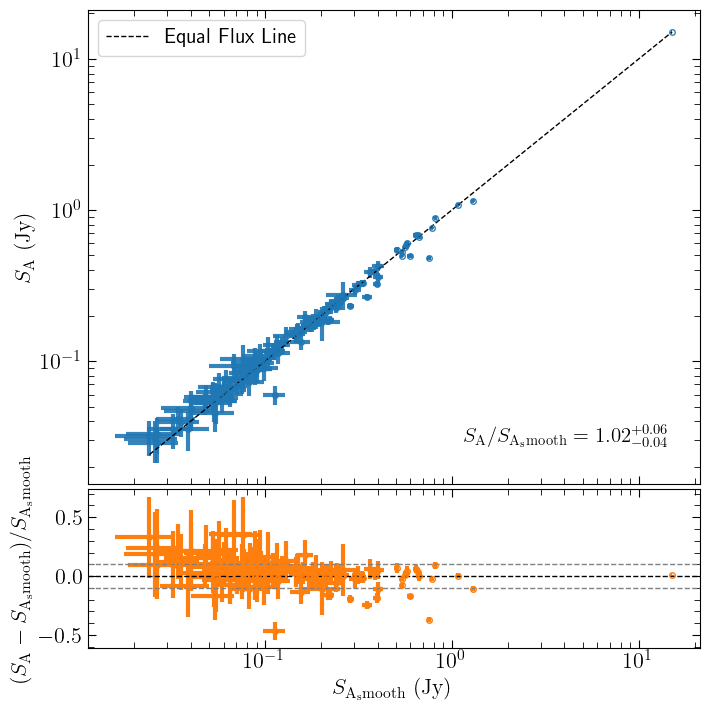

Matched sources: 149 / 159 (93.7%)


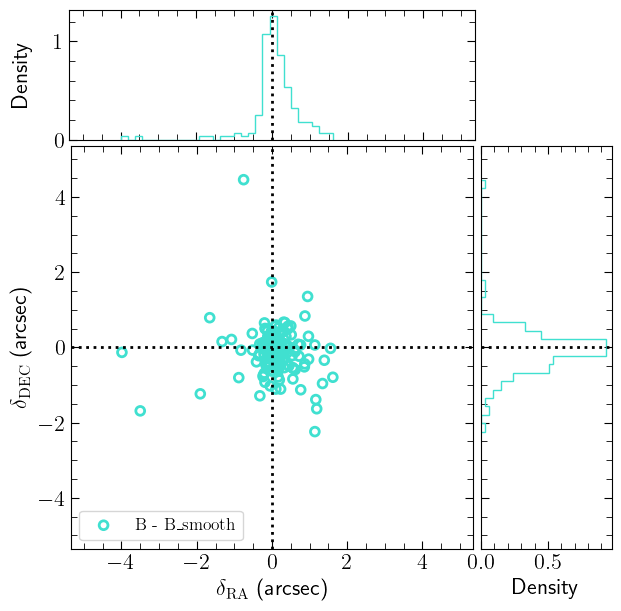

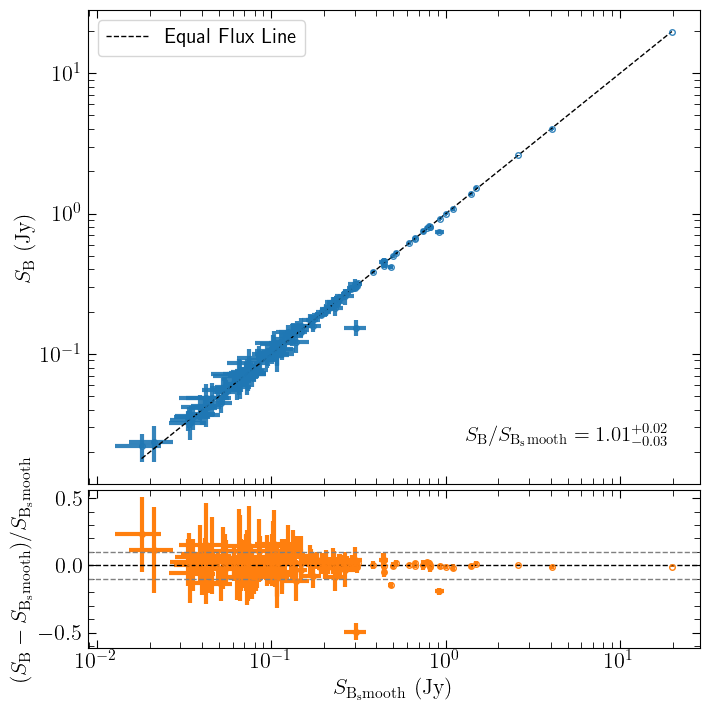

Matched sources: 159 / 175 (90.9%)


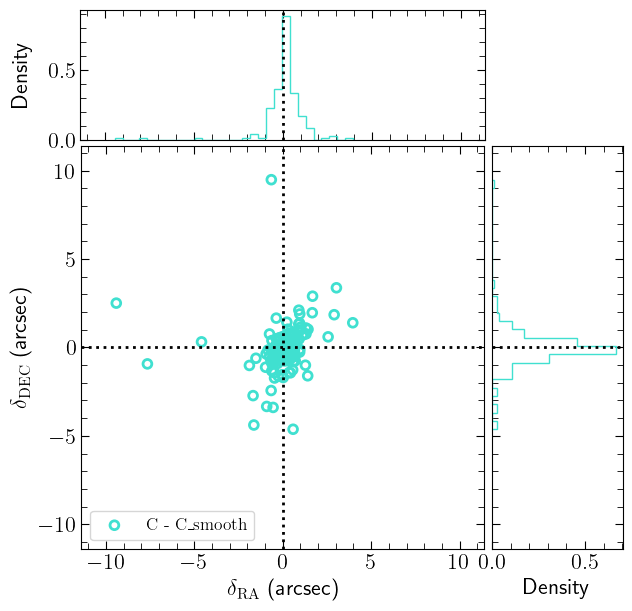

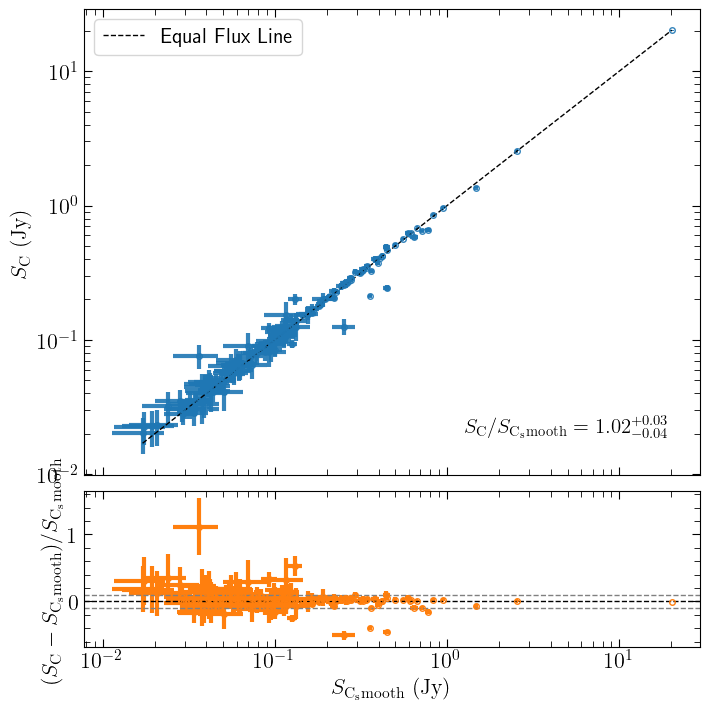

Matched sources: 161 / 189 (85.2%)


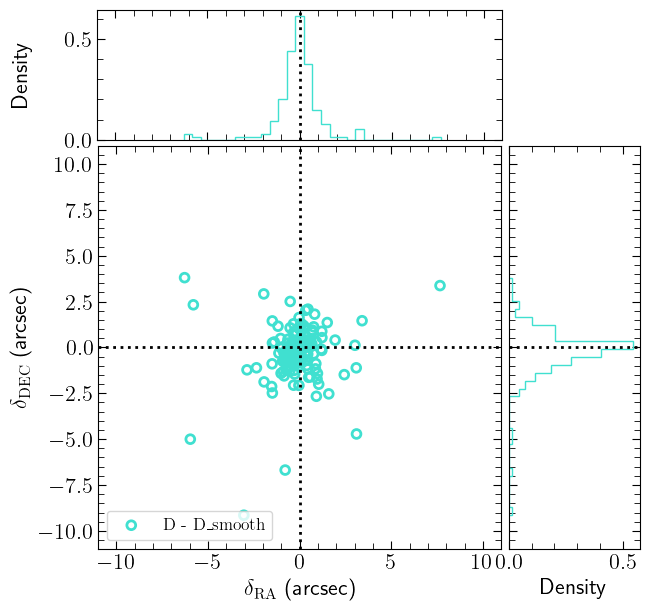

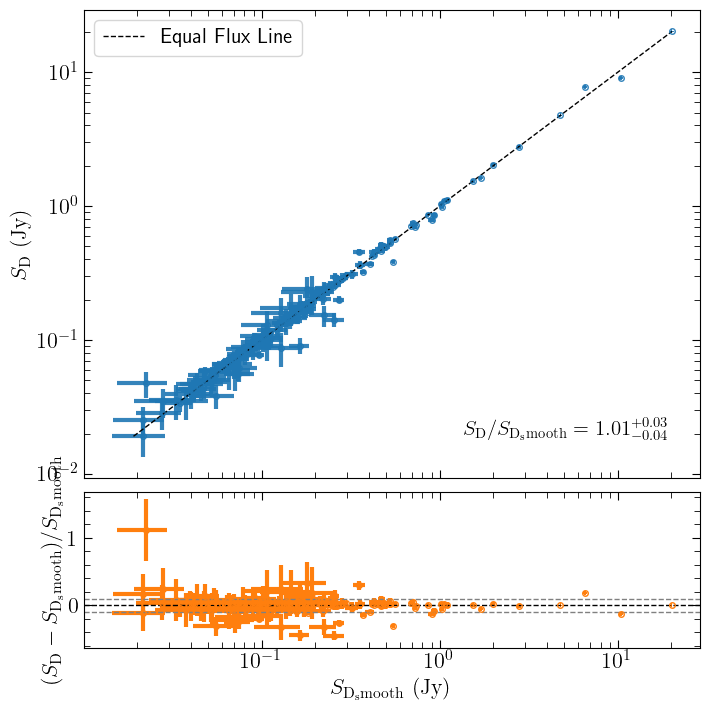

Matched sources: 154 / 170 (90.6%)


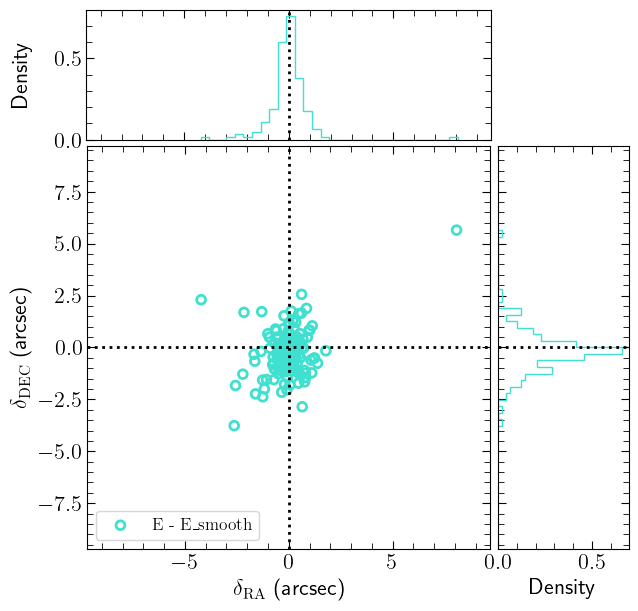

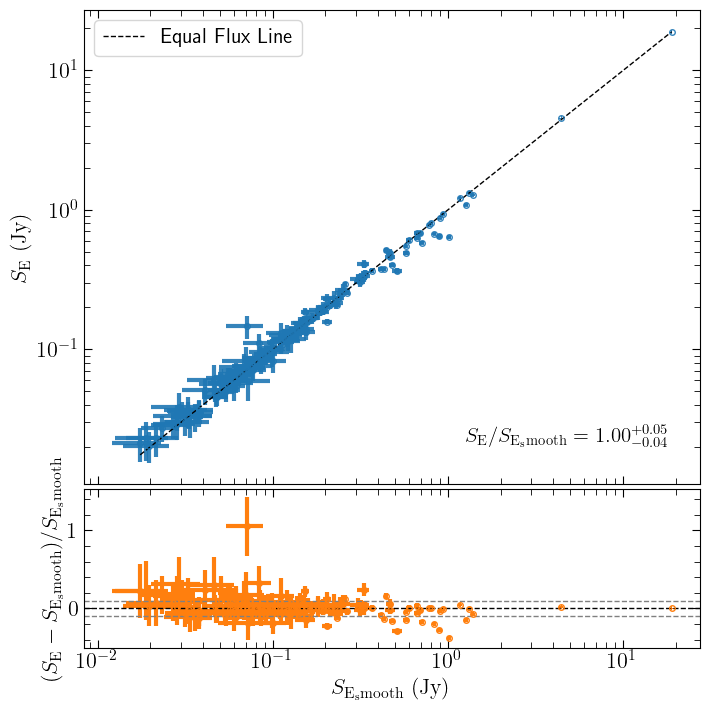

Matched sources: 151 / 166 (91.0%)


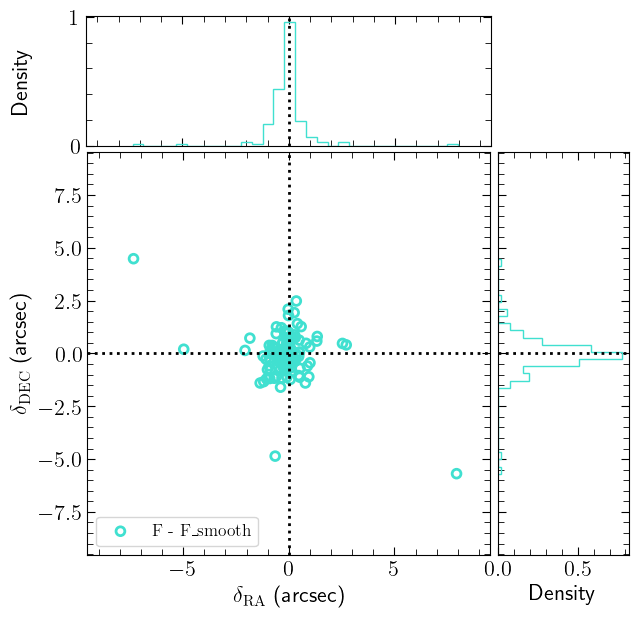

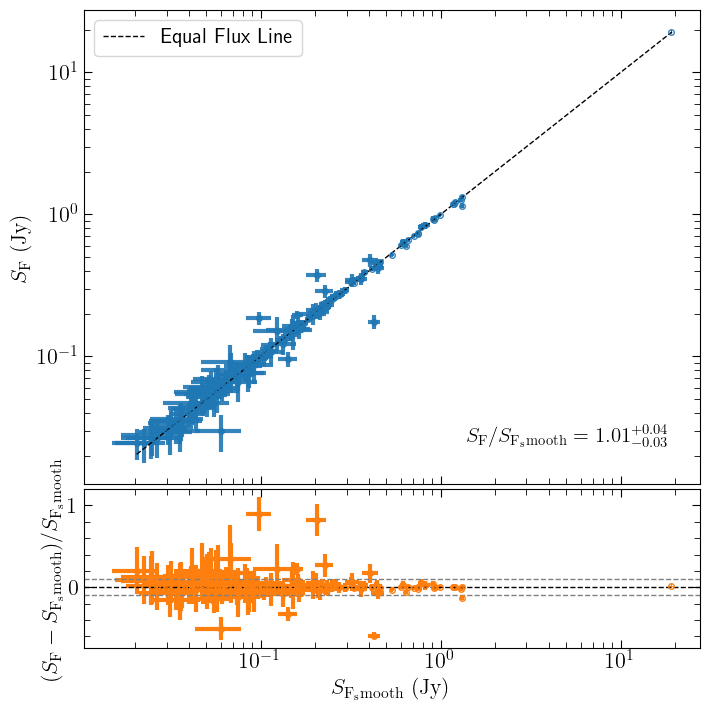

Matched sources: 163 / 178 (91.6%)


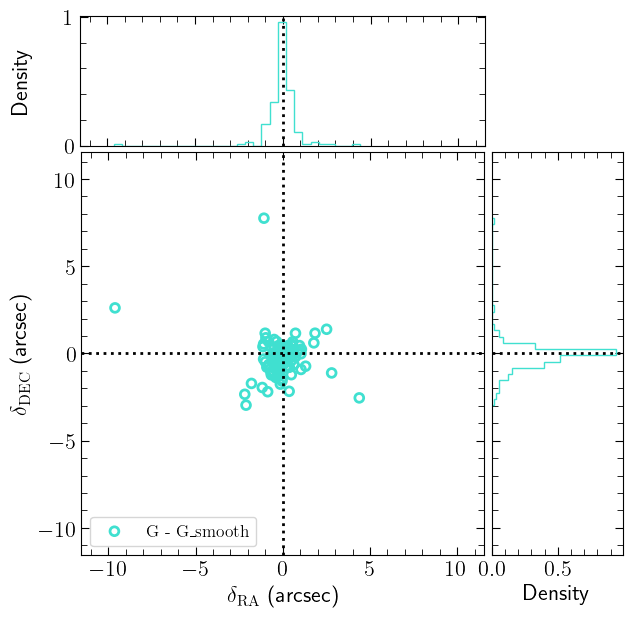

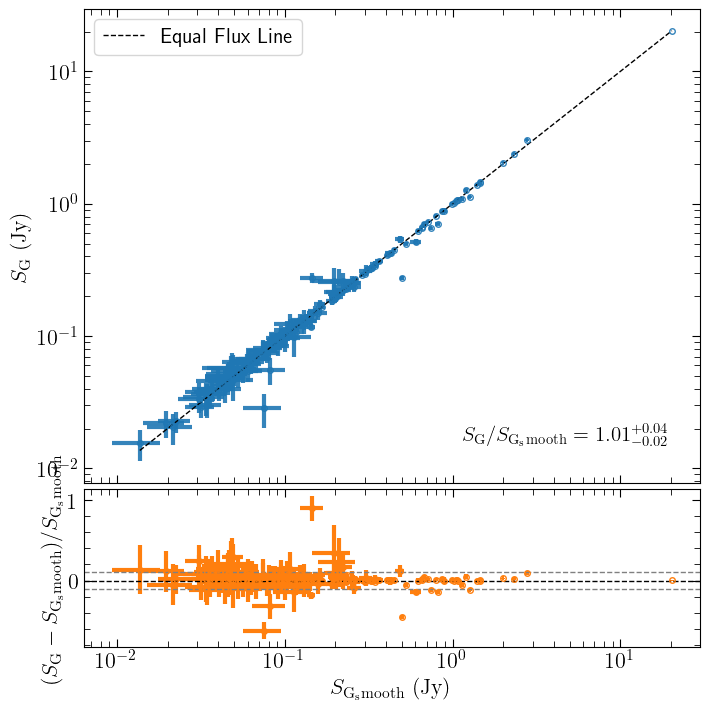

\begin{table}[ht]
\centering
\caption{Median flux ratios for all catalogue pairs.}
\begin{tabular}{l c}
\hline
Catalogue Pair & Median $S_\mathrm{orig}/S_\mathrm{smooth}$ \\
\hline
A, A_smooth & $1.02^{+0.06}_{-0.04}$ \\
B, B_smooth & $1.01^{+0.02}_{-0.03}$ \\
C, C_smooth & $1.02^{+0.03}_{-0.04}$ \\
D, D_smooth & $1.01^{+0.03}_{-0.04}$ \\
E, E_smooth & $1.00^{+0.05}_{-0.04}$ \\
F, F_smooth & $1.01^{+0.04}_{-0.03}$ \\
G, G_smooth & $1.01^{+0.04}_{-0.02}$ \\
\hline
\end{tabular}
\label{{tab:flux_ratios}}
\end{table}


In [8]:
process_catalog_pairs(catalog_pairs, match_radius=match_radius, save_plots=True)

Matched sources: 125 / 145 (86.2%)
Matched sources: 149 / 159 (93.7%)
Matched sources: 159 / 175 (90.9%)
Matched sources: 161 / 189 (85.2%)
Matched sources: 154 / 170 (90.6%)
Matched sources: 151 / 166 (91.0%)
Matched sources: 163 / 178 (91.6%)


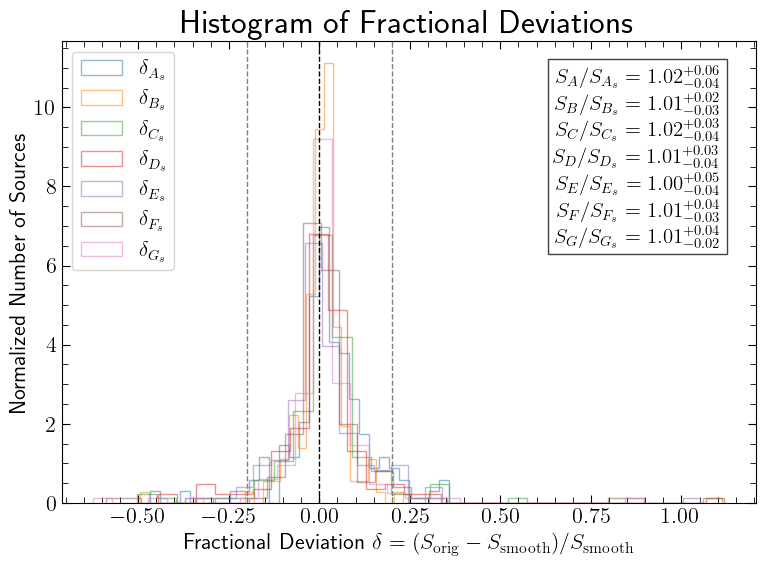

In [9]:
def plot_fracdev_histogram(catalog_pairs, match_radius=10*u.arcsec, bins=30):
    """
    Plot a histogram of fractional deviations for multiple catalog pairs,
    with median flux ratios annotated.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from itertools import cycle

    colors = cycle(plt.cm.tab10.colors)
    medians_text = []

    plt.figure(figsize=(8,6))

    for i, (cat1, cat2, _, _) in enumerate(catalog_pairs):
        name_orig = chr(ord('A') + i)
        name_smooth = f"{name_orig}_s"

        color = next(colors)

        # --- Match sources ---
        ra1, dec1, flux1, flux1_err, ra2, dec2, flux2, flux2_err = match_sources(
            cat1, cat2, match_radius=match_radius)

        # --- Compute median flux ratio ---
        ratio = flux1 / flux2
        median_ratio, errp, errm = compute_ratio_stats(ratio)
        medians_text.append(rf"$S_{{{name_orig}}}/S_{{{name_smooth}}}={median_ratio:.2f}^{{+{errp:.2f}}}_{{-{errm:.2f}}}$")

        # --- Fractional deviation ---
        frac_dev = (flux1 - flux2) / flux2

        # Plot histogram
        plt.hist(frac_dev, bins=bins, histtype='step', alpha=0.5, color=color, density=True, 
                 label=rf"$\delta_{{{name_smooth}}}$")

    # --- Plot decorations ---
    plt.xlabel(r"Fractional Deviation $\delta = (S_{\rm orig}-S_{\rm smooth}) / S_{\rm smooth}$")
    plt.ylabel("Normalized Number of Sources")
    plt.title("Histogram of Fractional Deviations")
    plt.axvline(0, color='k', ls='--', lw=1)
    plt.axvline(0.2, color='gray', ls='--', lw=1)
    plt.axvline(-0.2, color='gray', ls='--', lw=1)
    plt.legend(frameon=True, fontsize='small')
    # --- Annotate median flux ratios ---
    plt.text(0.95, 0.95, "\n".join(medians_text), transform=plt.gca().transAxes,
             ha='right', va='top', fontsize='small', bbox=dict(facecolor='white', alpha=0.75))

    plt.tight_layout()
    plt.show()

plot_fracdev_histogram(catalog_pairs, match_radius=match_radius)
